<a href="https://colab.research.google.com/github/HEVNAGI/CSST106-CS4B/blob/main/4B_MAGPANTAY_MP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Model Loading: Use TensorFlow to load a pre-trained YOLO model***

In [4]:
!pip install tensorflow opencv-python

In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2024-10-13 06:21:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  11.6MB/s    in 16s     

2024-10-13 06:21:38 (15.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-13 06:21:38--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [9]:
import tensorflow as tf
import cv2
import numpy as np

# Load YOLOv3 model
def load_yolo_model(weights_path, config_path):
    net = cv2.dnn.readNet(weights_path, config_path)
    return net

# Specify paths
weights_path = '/content/yolov3.weights'
config_path = '/content/yolov3.cfg'

# Load the model
yolo_model = load_yolo_model(weights_path, config_path)

# Print model information
print("YOLOv3 model loaded successfully!")


YOLOv3 model loaded successfully!


# ***Image Input: Select an image that contains multiple objects.***

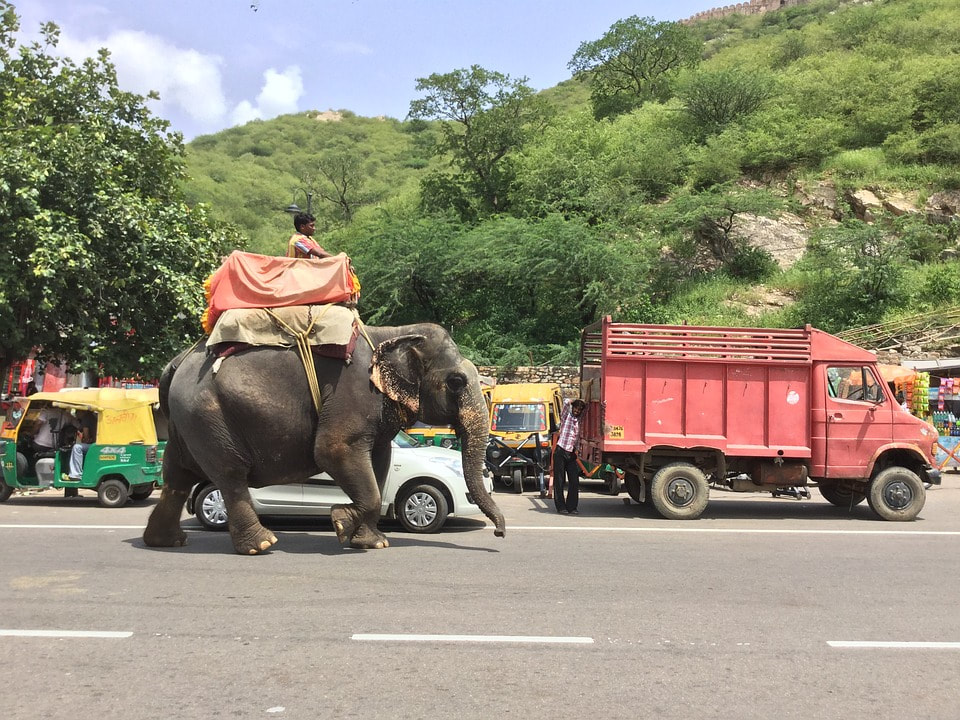

In [13]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load an image
image_path = '/content/CARSANDANIMALS.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)

# Display the image using cv2_imshow
cv2_imshow(image)

# ***Object Detection: Feed the selected image to the YOLO model to detect various objects within it.***

In [15]:
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names

--2024-10-13 06:32:16--  https://github.com/pjreddie/darknet/blob/master/data/coco.names
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘coco.names’

coco.names              [ <=>                ] 338.96K  --.-KB/s    in 0.1s    

2024-10-13 06:32:17 (2.72 MB/s) - ‘coco.names’ saved [347098]



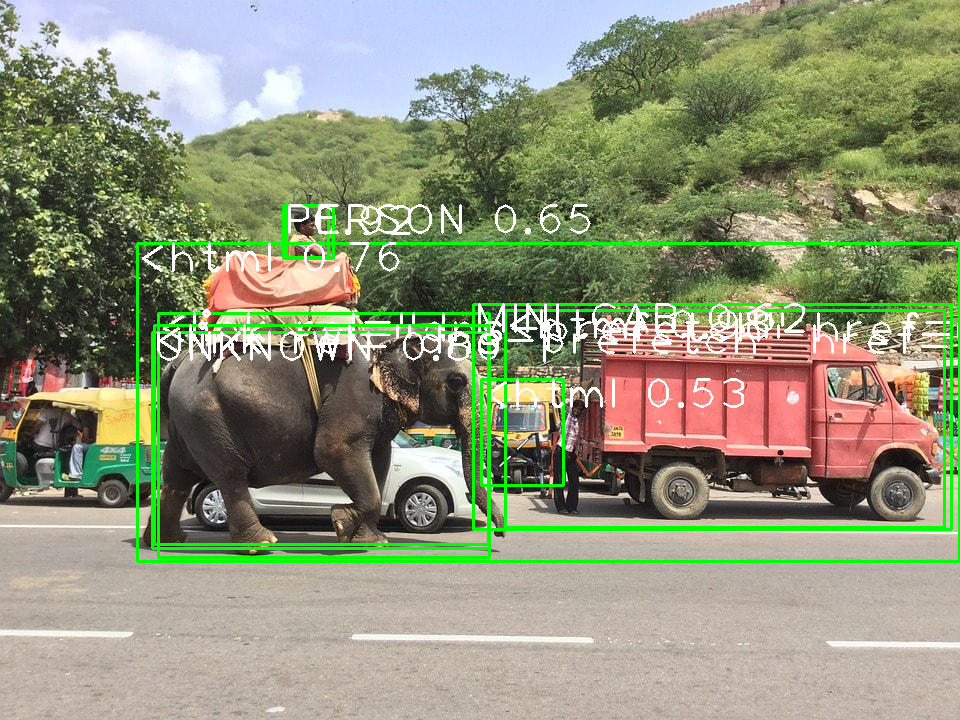

In [19]:
def detect_objects(image, model):
    height, width = image.shape[:2]
    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    model.setInput(blob)

    # Get output layer names
    layer_names = model.getLayerNames()
    output_layers_indices = model.getUnconnectedOutLayers()  # Get indices of the output layers
    output_layers = [layer_names[i - 1] for i in output_layers_indices]  # Adjust indices to 0-based

    # Perform forward pass to get detections
    outputs = model.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    # Analyze the outputs
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Filter out weak detections
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maxima Suppression to avoid overlapping boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    return boxes, confidences, class_ids, indexes

# Perform object detection
boxes, confidences, class_ids, indexes = detect_objects(image, yolo_model)

# Custom label mapping based on your specific requirements
object_labels = {
    "PERSON": "PEOPLE",   # Map detected class name "PERSON" to "PEOPLE"
    "TRUCK": "TRUCK",     # Keep the label as "TRUCK"
    "ELEPHANT": "ELEPHANT",# Keep the label as "ELEPHANT"
    "MINI CAB": "MINI CAB" # Keep the label as "MINI CAB"
}

# Load class labels from COCO dataset
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Draw bounding boxes and labels on the image
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        class_id = class_ids[i]

        # Use the COCO classes to map them to your desired labels
        detected_class = classes[class_id]  # Get the class name from COCO classes
        label = object_labels.get(detected_class, detected_class)  # Use custom label if available

        confidence = confidences[i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 2)

# Display the result
cv2_imshow(image)

# ***Visualization: Display the detected objects using bounding boxes and class labels.***

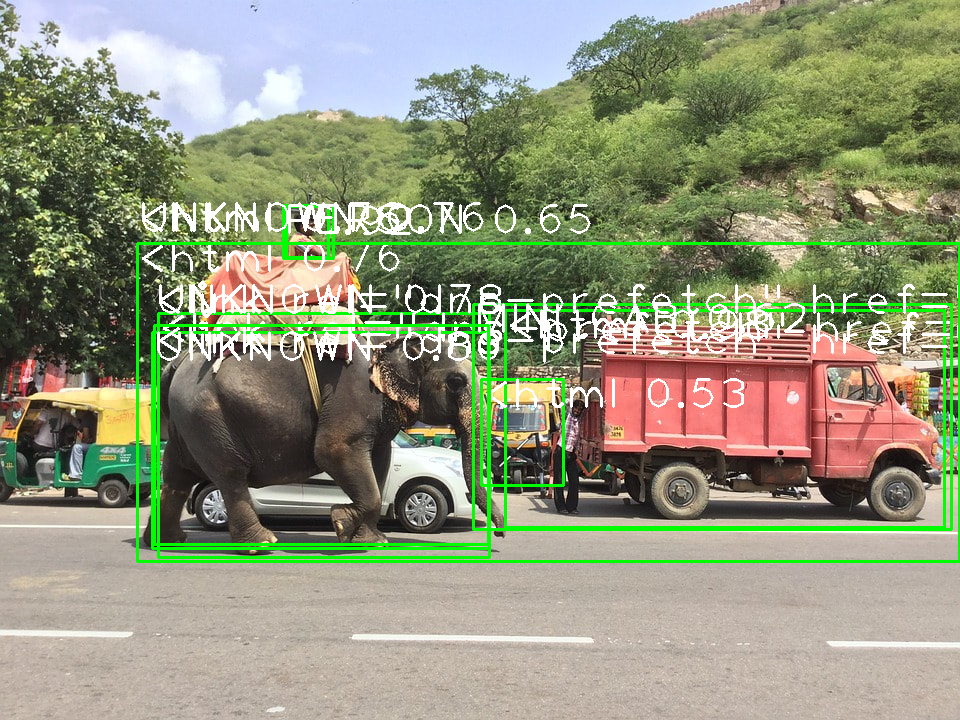

In [21]:
object_labels = {
    0: "PERSON",   # Assuming class_id 0 corresponds to "PERSON"
    1: "BICYCLE",  # Assuming class_id 1 corresponds to "BICYCLE"
    2: "CAR",      # Assuming class_id 2 corresponds to "CAR"
    3: "TRUCK",    # Assuming class_id 3 corresponds to "TRUCK"
    4: "ELEPHANT", # Assuming class_id 4 corresponds to "ELEPHANT"
    5: "MINI CAB", # Assuming class_id 5 corresponds to "MINI CAB"
}

# Load class labels from COCO dataset
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Draw bounding boxes and labels on the image
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        class_id = class_ids[i]

        # Check if class_id is in the custom labels dictionary
        if class_id in object_labels:
            label = object_labels[class_id]
        else:
            label = "UNKNOWN"  # Default label for unknown classes

        confidence = confidences[i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 2)

# Display the result with bounding boxes and labels
cv2_imshow(image)

# ***Testing: Test the model on at least three different images to compare its performance and observe its accuracy.***

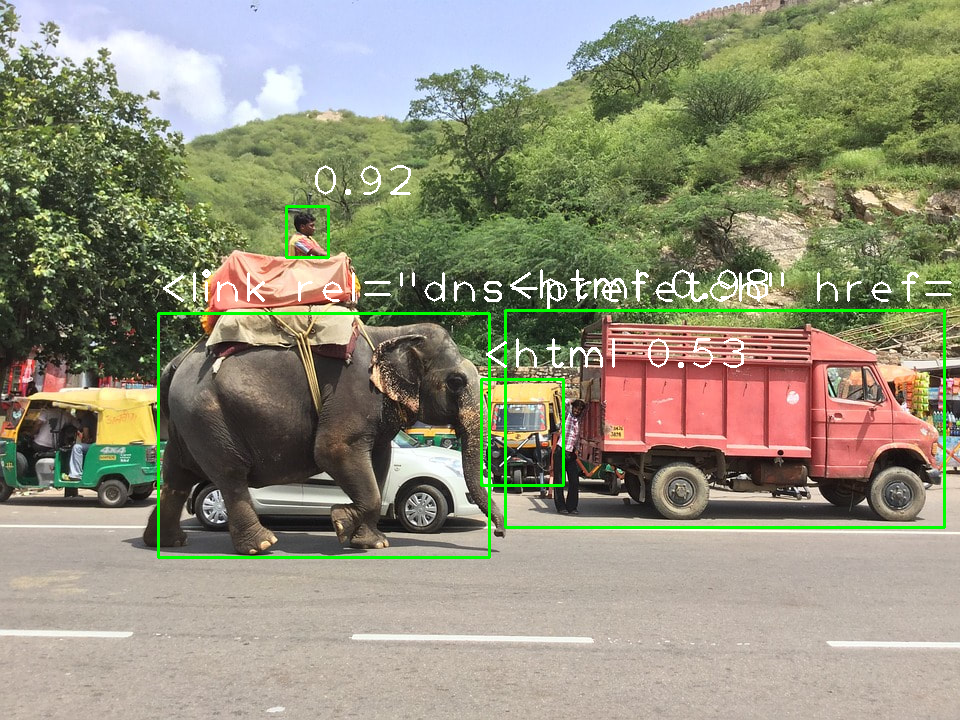

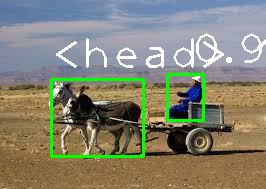

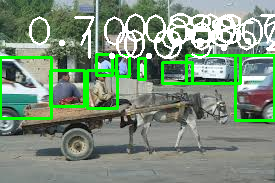

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load class labels from COCO dataset
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Function to draw bounding boxes and labels on the image
def draw_boxes(image, boxes, confidences, class_ids, indexes, classes):
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_id = class_ids[i]
            label = classes[class_id] if class_id < len(classes) else "UNKNOWN"
            confidence = confidences[i]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 2)
    return image

# Function to process and detect objects in a list of images
def test_yolo_on_images(image_paths, model, classes):
    for image_path in image_paths:
        image = cv2.imread(image_path)
        boxes, confidences, class_ids, indexes = detect_objects(image, model)
        result_image = draw_boxes(image, boxes, confidences, class_ids, indexes, classes)

        # Display the result
        cv2_imshow(result_image)

# List of test images
test_images = [
    '/content/CARSANDANIMALS.jpg',  # Replace with the actual paths to your test images
    '/content/21.jpg',
    '/content/images.jpg'
]

# Test the model on multiple images
test_yolo_on_images(test_images, yolo_model, classes)



Processing time for /content/CARSANDANIMALS.jpg: 1.19 seconds
Precision for /content/CARSANDANIMALS.jpg: 0.00, Recall: 0.00


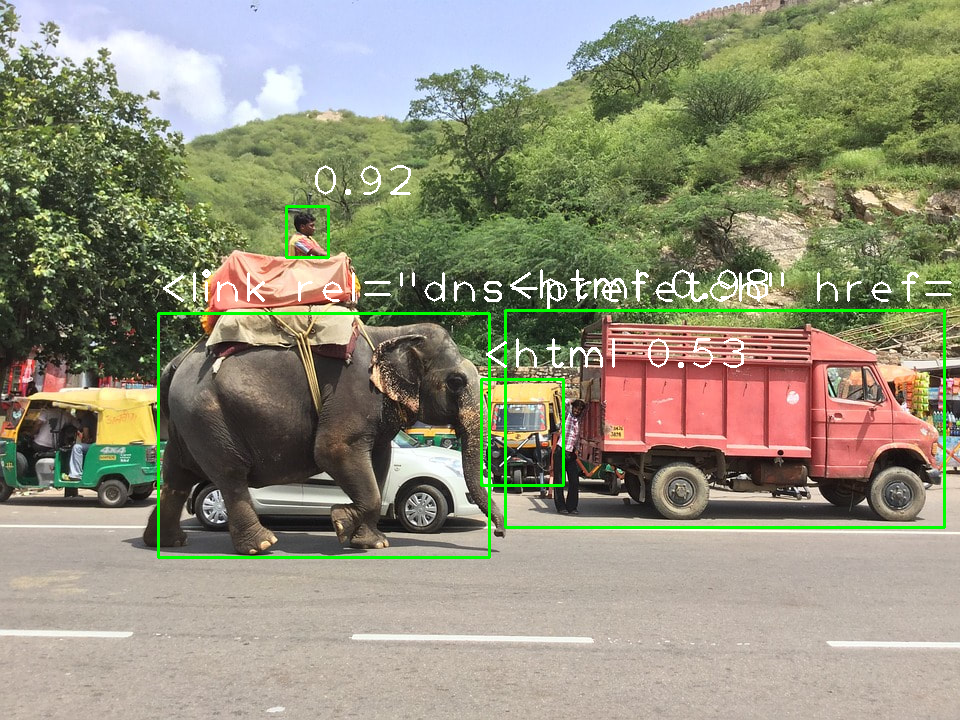

Processing time for /content/21.jpg: 1.52 seconds
Precision for /content/21.jpg: 0.00, Recall: 0.00


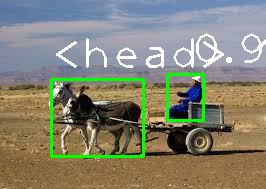

Processing time for /content/images.jpg: 1.22 seconds
Precision for /content/images.jpg: 0.00, Recall: 0.00


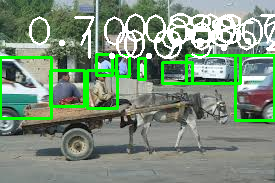

In [29]:
import cv2
import numpy as np
import time  # Importing the time module
from google.colab.patches import cv2_imshow

# Load class labels from COCO dataset
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Function to draw bounding boxes and labels on the image
def draw_boxes(image, boxes, confidences, class_ids, indexes, classes):
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_id = class_ids[i]
            label = classes[class_id] if class_id < len(classes) else "UNKNOWN"
            confidence = confidences[i]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 2)
    return image

# Function to calculate precision and recall
def calculate_metrics(true_labels, detected_labels):
    # Calculate true positives, false positives, and false negatives
    true_positives = len(set(true_labels) & set(detected_labels))
    false_positives = len(set(detected_labels) - set(true_labels))
    false_negatives = len(set(true_labels) - set(detected_labels))

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

# Function to process and detect objects in a list of images
def test_yolo_on_images(image_paths, model, classes, ground_truths=None):
    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)

        start_time = time.time()  # Start timing
        boxes, confidences, class_ids, indexes = detect_objects(image, model)
        end_time = time.time()  # End timing

        result_image = draw_boxes(image, boxes, confidences, class_ids, indexes, classes)

        # Display processing time
        processing_time = end_time - start_time
        print(f"Processing time for {image_path}: {processing_time:.2f} seconds")

        # If ground truths are provided, calculate metrics
        if ground_truths is not None:
            detected_labels = [classes[class_ids[i]] for i in range(len(boxes)) if i in indexes]
            precision, recall = calculate_metrics(ground_truths[i], detected_labels)
            print(f"Precision for {image_path}: {precision:.2f}, Recall: {recall:.2f}")

        # Display the result
        cv2_imshow(result_image)

# Example list of test images and their corresponding ground truths
test_images = [
    '/content/CARSANDANIMALS.jpg',
    '/content/21.jpg',
    '/content/images.jpg'
]

# Corresponding ground truths (list of actual classes for each image)
# Replace with actual classes if known
ground_truths = [
    ["PERSON", "CAR"],  # Example for CARSANDANIMALS.jpg
    ["BICYCLE", "TRUCK"],  # Example for 21.jpg
    ["ELEPHANT", "MINI CAB"]  # Example for images.jpg
]

# Test the model on multiple images
test_yolo_on_images(test_images, yolo_model, classes, ground_truths)

